<a href="https://colab.research.google.com/github/mohammadreza-mohammadi94/Deep-Learning-Projects/blob/main/SMS_Spam_Detection/sms_spam_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Dataset

In [3]:
import os
from google.colab import userdata
os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

In [5]:
!mkdir ~/kaggle
!cp kaggle.json ~/kaggle
!chmod 600 ~/kaggle/kaggle.json
!kaggle datasets download uciml/sms-spam-collection-dataset
!unzip sms-spam-collection-dataset.zip
!rm -rf sms-spam-collection-dataset.zip

# Libraries

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


# Load & Process Data

In [13]:
df = pd.read_csv("spam.csv", encoding="latin-1")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


> Process Columns Name

In [14]:
# Remove cols and rename
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
df.columns = ["label", "text"]
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


> Check Labels Distribution

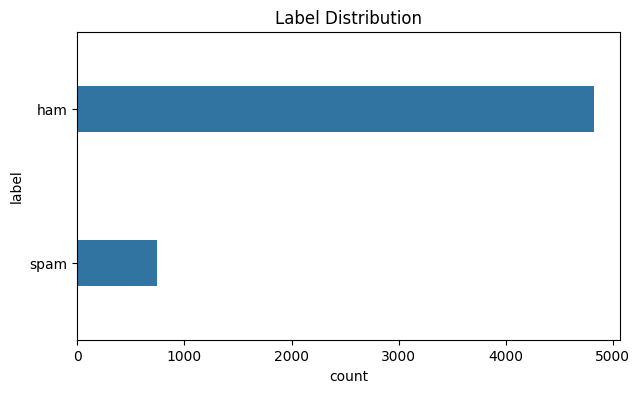

In [21]:
plt.figure(figsize=(7,4))
sns.countplot(df["label"], width=0.3);
plt.title("Label Distribution");

> Convert Labels

In [22]:
df["label"] = df["label"].map({"ham": 0, "spam": 1})
df.head(2)

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...


> Text Cleaning

In [32]:
def clean_text(text):
    text = text.lower()
    # Keep letters, numbers, and common symbols that might be relevant for spam
    text = re.sub(r'[^a-z0-9\s\$\!\?\%]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['cleaned_text'] = df['text'].apply(clean_text)
df.head(2)

,label,text,cleaned_text
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni


# Train/Test Split

In [36]:
X = df['cleaned_text']
y = df['label']

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"X Train Shape: {X_train_text.shape}")
print(f"X Test Shape: {X_test_text.shape}")

X Train Shape: (4457,)
X Test Shape: (1115,)


# Tokenization

In [38]:
VOCAB_SIZE = 7000
sequence_lengths = X_train_text.apply(lambda x: len(x.split()))
MAX_SEQ_LEN = int(np.percentile(sequence_lengths, 95))
print(f"Max Sequence Length: {MAX_SEQ_LEN}")

Max Sequence Length: 32


In [39]:
vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQ_LEN
)

vectorize_layer.adapt(X_train_text)

# Model Definition

In [104]:
EMBEDDING_DIM = 64
LSTM_UNITS = 32
DROPOUT_RATE = 0.5
L2_REG = 0.002

input_layer = Input(shape=(MAX_SEQ_LEN,), dtype=tf.int64, name="input_layer")
embedding_layer = Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=EMBEDDING_DIM,
    mask_zero=True,
    name="embedding_layer"
)(input_layer)
bilstm_layer = Bidirectional(LSTM(
    LSTM_UNITS,
    return_sequences=False,
    kernel_regularizer=tf.keras.regularizers.l2(L2_REG),
    recurrent_regularizer=tf.keras.regularizers.l2(L2_REG)
))(embedding_layer)
dropout_layer = Dropout(DROPOUT_RATE)(bilstm_layer)
output_layer = Dense(1, activation="sigmoid", name="output_layer")(dropout_layer)

model = Model(inputs=input_layer, outputs=output_layer)

# Compiling the model
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_layer     │ (None, 32, 64)    │    448,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_12        │ (None, 32)        │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_12    │ (None, 64)        │     24,832 │ embedding_layer[… │
│ (Bidirectional)     │                   │            │ not_equal_12[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 64)        │          0 │ bidirectional_12… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 1)         │         65 │ dropout_12[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 472,897 (1.80 MB)

 Trainable params: 472,897 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

# Training

In [105]:
y_train_array = y_train.to_numpy()
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_array),
    y=y_train_array
)
class_weight_dict = dict(enumerate(class_weights))
print("\nComputed Class Weights to handle imbalance:")
print(f"Weight for class 0 (ham): {class_weight_dict[0]:.2f}")
print(f"Weight for class 1 (spam): {class_weight_dict[1]:.2f}")


Computed Class Weights to handle imbalance:
Weight for class 0 (ham): 0.58
Weight for class 1 (spam): 3.73


In [106]:
EPOCHS = 10
BATCH_SIZE = 16
PATIENCE = 2

callbacks = [
    ModelCheckpoint('best_spam_model.keras', save_best_only=True, monitor='val_accuracy', mode='max'),
    EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)
]

# Split the training data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_text, y_train,
    test_size=0.15, # Use the same split percentage as validation_split
    random_state=42,
    stratify=y_train
)

# Apply TextVectorization outside the model
X_train_vectorized = vectorize_layer(X_train_split)
X_val_vectorized = vectorize_layer(X_val_split)


# Create TensorFlow Datasets for training and validation from vectorized data
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_vectorized, y_train_split)).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_vectorized, y_val_split)).batch(BATCH_SIZE)


print("\n--- Starting Model Training ---")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset, # Use validation_data instead of validation_split
    class_weight=class_weight_dict,
    callbacks=callbacks
)


--- Starting Model Training ---
Epoch 1/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.7711 - loss: 0.9112 - val_accuracy: 0.9626 - val_loss: 0.3129
Epoch 2/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9725 - loss: 0.2266 - val_accuracy: 0.9791 - val_loss: 0.1727
Epoch 3/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9912 - loss: 0.1210 - val_accuracy: 0.9836 - val_loss: 0.1364
Epoch 4/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9965 - loss: 0.0900 - val_accuracy: 0.9791 - val_loss: 0.1295
Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9932 - loss: 0.0698 - val_accuracy: 0.9836 - val_loss: 0.1282
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9985 - loss: 0.0513 - val_accuracy: 0.9806 - val_loss: 0.1175
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9996 - loss: 0.0430 - val_accuracy: 0.9821 - val_loss: 0.1205
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy:

# Evaluation

In [107]:
# Evaluate the model on the test set
X_test_vectorized = vectorize_layer(X_test_text)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_vectorized, y_test)).batch(BATCH_SIZE) # Create a dataset and batch it
test_loss, test_accuracy = model.evaluate(test_dataset) # Use the dataset for evaluation

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Make predictions on the test set
# Create a dataset for predictions as well
predict_dataset = tf.data.Dataset.from_tensor_slices(X_test_vectorized).batch(BATCH_SIZE)
y_pred = model.predict(predict_dataset)
y_pred_classes = (y_pred > 0.5).astype(int)

# Display classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9868 - loss: 0.0920

Test Loss: 0.1111
Test Accuracy: 0.9830
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.93      0.94      0.94       149

    accuracy                           0.98      1115
   macro avg       0.96      0.96      0.96      1115
weighted avg       0.98      0.98      0.98      1115


Confusion Matrix:
[[956  10]
 [  9 140]]


# Training History Visualization

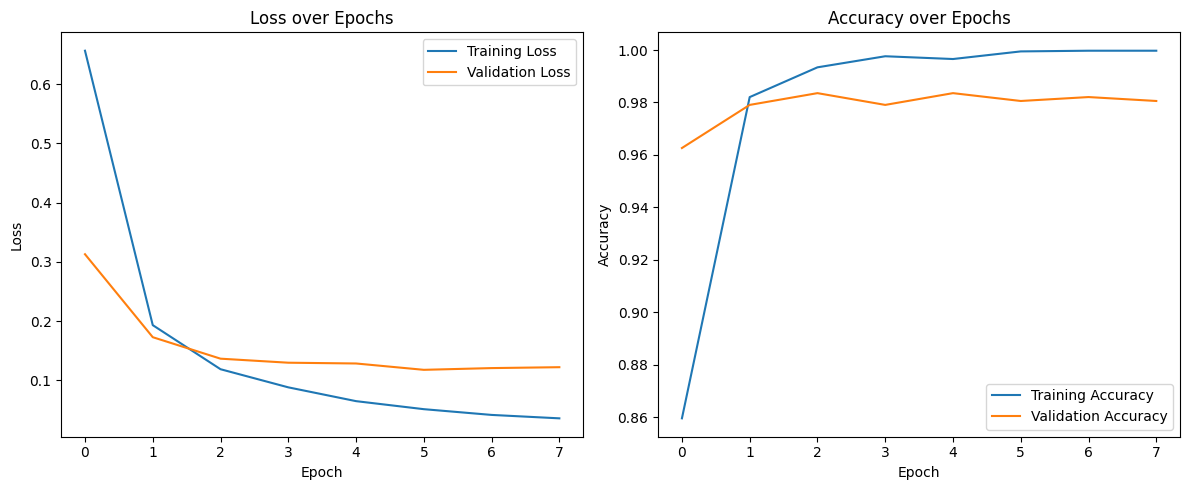

In [108]:
# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()